# Blending Notebook
This is a notebook to experiment a blending model

In [1]:
%matplotlib inline

## Dataset loading
So far, a single source dataset is used

In [2]:
#% Imports
import pandas as pd

#% Data import
#% engine=python because C engine has an error with a character in the middle of
## the file. May be slower but works.

df = pd.read_csv('../Datasets/macdonalds_for_guillaume.csv', engine='python')

## Dataset structure

This work has been moved to the file [dataset.py](dataset.py)

In [3]:
from dataset import Dataset

Using TensorFlow backend.


## Utility functions
* examine_cv gives a quick overview of a cross validation result
* filter_text filters characters from a text
* show_diffs and save_diffs compare predictions of different estimators
* df_corr plots the correlation matrix of a dataframe

This work has been moved to [utils_npi.py](utils_npi.py)

In [4]:
from npi_utils import examine_cv, filter_text, show_diffs, save_diffs, df_corr

## Models

These classes are used to handle different kind of models seamlessly  
This has been moved to the [models.py](models.py) file

In [5]:
import models

## Adding models
Models added :
* A naive Bayes model
* A linear SVM
* A RBF kernel SVM
* A polynomial kernel SVM
* GRU with 1 layer
* GRU with 2 layer
* LSTM with 1 layer
* LSTM with 2 layer
* Bi-directional GRU with 1 layer
* Bi-directional GRU with 2 layers
* Bi-directional LSTM with 1 layer
* Bi-directional LSTM with 2 layers -> With several epochs
* Random forest

In [6]:
models_list = []
models_list.append(models.NaiveBayesModelHandler())
models_list.append(models.LinearSVCModelHandler())

#% These models are slow, and not really good
#models.append(PolySVCModelHandler())
#models.append(RBFSVCModelHandler())

models_list.append(models.GRU1ModelHandler())
models_list.append(models.GRU2ModelHandler())
models_list.append(models.LSTM1ModelHandler())
models_list.append(models.LSTM2ModelHandler())
models_list.append(models.BiDirGRU1ModelHandler())
models_list.append(models.BiDirGRU2ModelHandler())
models_list.append(models.BiDirLSTM1ModelHandler())
models_list.append(models.BiDirLSTM2ModelHandler())

models_list.append(models.RandomForestModelHandler())

## Adding datasets
First we add the basic texts set.  
Stemming may help some models. So we will create an additional dataset with the stemmed texts

In [7]:
from nltk import SnowballStemmer

#% Datasets
datasets = []

#% Basic texts
texts = df['text']
y = df['neg_pi'].values

#% Stem words
stemmer = SnowballStemmer("english")

stemmed_texts = [' '.join([stemmer.stem(w) for w in filter_text(t).split()]) for t in texts]

print('mcdonalds')
datasets.append(Dataset(texts, y, 'mcdonalds'))

print('stemmed mcdonalds')
datasets.append(Dataset(stemmed_texts, y, 'stemmed mcdonalds'))

for dataset in datasets:
    print(dataset.name, ', vocabulary size :', dataset.vocabulary_size)

mcdonalds
stemmed mcdonalds
mcdonalds , vocabulary size : 42239
stemmed mcdonalds , vocabulary size : 36032


## Start the analysis

In [8]:
import time
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss , roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

def blending_analysis(models_list, tag=""):
    #% use 10 folds cv
    folds = 10

    #% Blending_ratio
    #% We train on 1-blend_rate, blend on blend_rate
    blend_rate = 0.2

    cv_accuracies = []
    cv_rocaucs = []
    cv_logloss = []
    cv_f1s = []

    blending_path = './blending' + str(int(blend_rate*100))
    if not os.path.isdir(blending_path):
        os.mkdir(blending_path)


    #% Result file
    result_file = 'result.csv'

    #% Clear the result file
    clear_file = False

    #% Models/Datasets done
    models_dataset_done = []

    if os.path.exists(result_file) and not clear_file:
        result_content = pd.read_csv(result_file, engine='python')
        models_dataset_done = [(e[0], e[1]) for e in result_content[['model','dataset']].values]
    else:
        clear_file = True

    if clear_file:
        f = open(result_file, "w")
        f.write('model,dataset,accuracies,mean_acc,std_acc,f1_scores,mean_f1,std_f1,log_loss,mean_log_loss,std_log_loss,roc_auc_scores,mean_roc_auc,std_roc_auc,ms_time\n')
        f.close()

    blending_model_name = "Blending" + str(tag) + " " + str(int(round(100*(1-blend_rate)))) + " train " + str(int(round(100*(blend_rate)))) + " blend"

    for dataset in datasets:
        #% Check if it has already been done
        if (blending_model_name, dataset.name) in models_dataset_done:
            print('This has been done already.')
            continue

        kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
        current_fold = 1

        dataset_path = os.path.join(blending_path, dataset.name)
        if not os.path.isdir(dataset_path):
            os.mkdir(dataset_path)

        for train_idx, test_idx in kfold.split(dataset.X, dataset.y):
            print('-----')
            print('Fold', current_fold)
            train, test = dataset.split_index(train_idx, test_idx)

            #% Blend on 20% of the train set
            train, blend = dataset.split(blend_rate)

            fold_path = os.path.join(dataset_path, str(current_fold) + '_' + str(folds))
            if not os.path.isdir(fold_path):
                os.mkdir(fold_path)

            for model in models_list:
                model_name = ' '.join(model.get_info())
                print(model_name)

                model_dir = os.path.join(fold_path, model_name)
                if not os.path.isdir(model_dir):
                    os.mkdir(model_dir)

                #% Check if the model has already been fit
                preds_test_file = os.path.join(model_dir, 'preds_test.csv')
                preds_blend_file = os.path.join(model_dir, 'preds_blend.csv')
                if not os.path.isfile(preds_test_file):
                    #% This model have no prediction yet
                    ## fit predict with it
                    model.fit(train)

                    #% Write predictions for blending & test
                    preds = model.predict(blend)
                    thefile = open(preds_blend_file,'w')
                    for item in preds:
                        thefile.write("%s\n" % item)
                    thefile.close()

                    preds = model.predict(test)
                    thefile = open(preds_test_file,'w')
                    for item in preds:
                        thefile.write("%s\n" % item)
                    thefile.close()

            Zblend = None
            Ztest = None

            #% Build the prediction matrices
            #% It is a concatenation of the predictions of all models
            for model in models_list:
                model_name = ' '.join(model.get_info())
                model_dir = os.path.join(fold_path, model_name)
                preds_test_file = os.path.join(model_dir, 'preds_test.csv')
                preds_blend_file = os.path.join(model_dir, 'preds_blend.csv')

                if Zblend is None:
                    Zblend = pd.read_csv(preds_blend_file, names=[model_name], header=None)
                    Ztest = pd.read_csv(preds_test_file, names=[model_name], header=None)
                else:
                    df = pd.read_csv(preds_blend_file, names=[model_name], header=None)
                    Zblend = pd.concat([Zblend, df], axis=1)
                    df = pd.read_csv(preds_test_file, names=[model_name], header=None)
                    Ztest = pd.concat([Ztest, df], axis=1)

            #% Train a logReg on the predictions
            lr = LogisticRegression(solver="lbfgs", max_iter=2000, n_jobs = -1)
            lr.fit(Zblend, blend.y)

            #% Test the blending
            soft = lr.predict_proba(Ztest)[:,1]
            y_pred = np.round(soft)

            #% Get measures
            ## F1 score for class 1
            cv_f1s.append(classification_report(test.y, y_pred, output_dict=True)['1']['f1-score'])

            ## Accuracy
            cv_accuracies.append(lr.score(Ztest, test.y))

            #% Log loss
            cv_logloss.append(log_loss(test.y, soft))

            #% ROC AUC score
            cv_rocaucs.append(roc_auc_score(test.y, soft))

            print(lr.score(Ztest, test.y), roc_auc_score(test.y, soft), classification_report(test.y, y_pred, output_dict=True)['1']['f1-score'])

            current_fold += 1


        print('log loss')
        mean_logloss, std_logloss = examine_cv(cv_logloss)
        print('Accuracy scores')
        mean_acc, std_acc = examine_cv(cv_accuracies)
        print('f1 scores')
        mean_f1, std_f1 = examine_cv(cv_f1s)
        print('roc scores')
        mean_roc, std_roc = examine_cv(cv_rocaucs)
        print(mean_roc-2*std_roc)


        #% Add entry to result file
        file_entry = []
        file_entry.append(blending_model_name)
        file_entry.append(dataset.name)
        file_entry.append(';'.join([str(s) for s in sorted(cv_accuracies)]))
        file_entry.append(str(mean_acc))
        file_entry.append(str(std_acc))
        file_entry.append(';'.join([str(s) for s in sorted(cv_f1s)]))
        file_entry.append(str(mean_f1))
        file_entry.append(str(std_f1))
        file_entry.append(';'.join([str(s) for s in sorted(cv_logloss)]))
        file_entry.append(str(mean_logloss))
        file_entry.append(str(std_logloss))
        file_entry.append(';'.join([str(s) for s in sorted(cv_rocaucs)]))
        file_entry.append(str(mean_roc))
        file_entry.append(str(std_roc))
        file_entry.append(str('N/A'))


        f = open(result_file, "a")
        f.write(','.join(file_entry) + '\n')
        f.close()

In [9]:
blending_analysis(models_list, tag="")

This has been done already.
This has been done already.


In [10]:
models_list_reduced = []
models_list_reduced.append(models.LinearSVCModelHandler())

models_list_reduced.append(models.LSTM2ModelHandler())

models_list_reduced.append(models.RandomForestModelHandler())
blending_analysis(models_list_reduced, tag="-reduced")

This has been done already.
This has been done already.


In [11]:
models_list_min = []
models_list_min.append(models.LSTM2ModelHandler())
models_list_min.append(models.RandomForestModelHandler())
blending_analysis(models_list_min, tag="-minimal")

This has been done already.
This has been done already.


## In-depth analysis

In [12]:
models_list = []
models_list.append(models.NaiveBayesModelHandler())
models_list.append(models.LinearSVCModelHandler())

#% These models are slow, and not really good
#models.append(PolySVCModelHandler())
#models.append(RBFSVCModelHandler())

models_list.append(models.GRU1ModelHandler())
models_list.append(models.GRU2ModelHandler())
models_list.append(models.LSTM1ModelHandler())
models_list.append(models.LSTM2ModelHandler())
models_list.append(models.BiDirGRU1ModelHandler())
models_list.append(models.BiDirGRU2ModelHandler())
models_list.append(models.BiDirLSTM1ModelHandler())
models_list.append(models.BiDirLSTM2ModelHandler())

models_list.append(models.RandomForestModelHandler())

-----
Fold 1


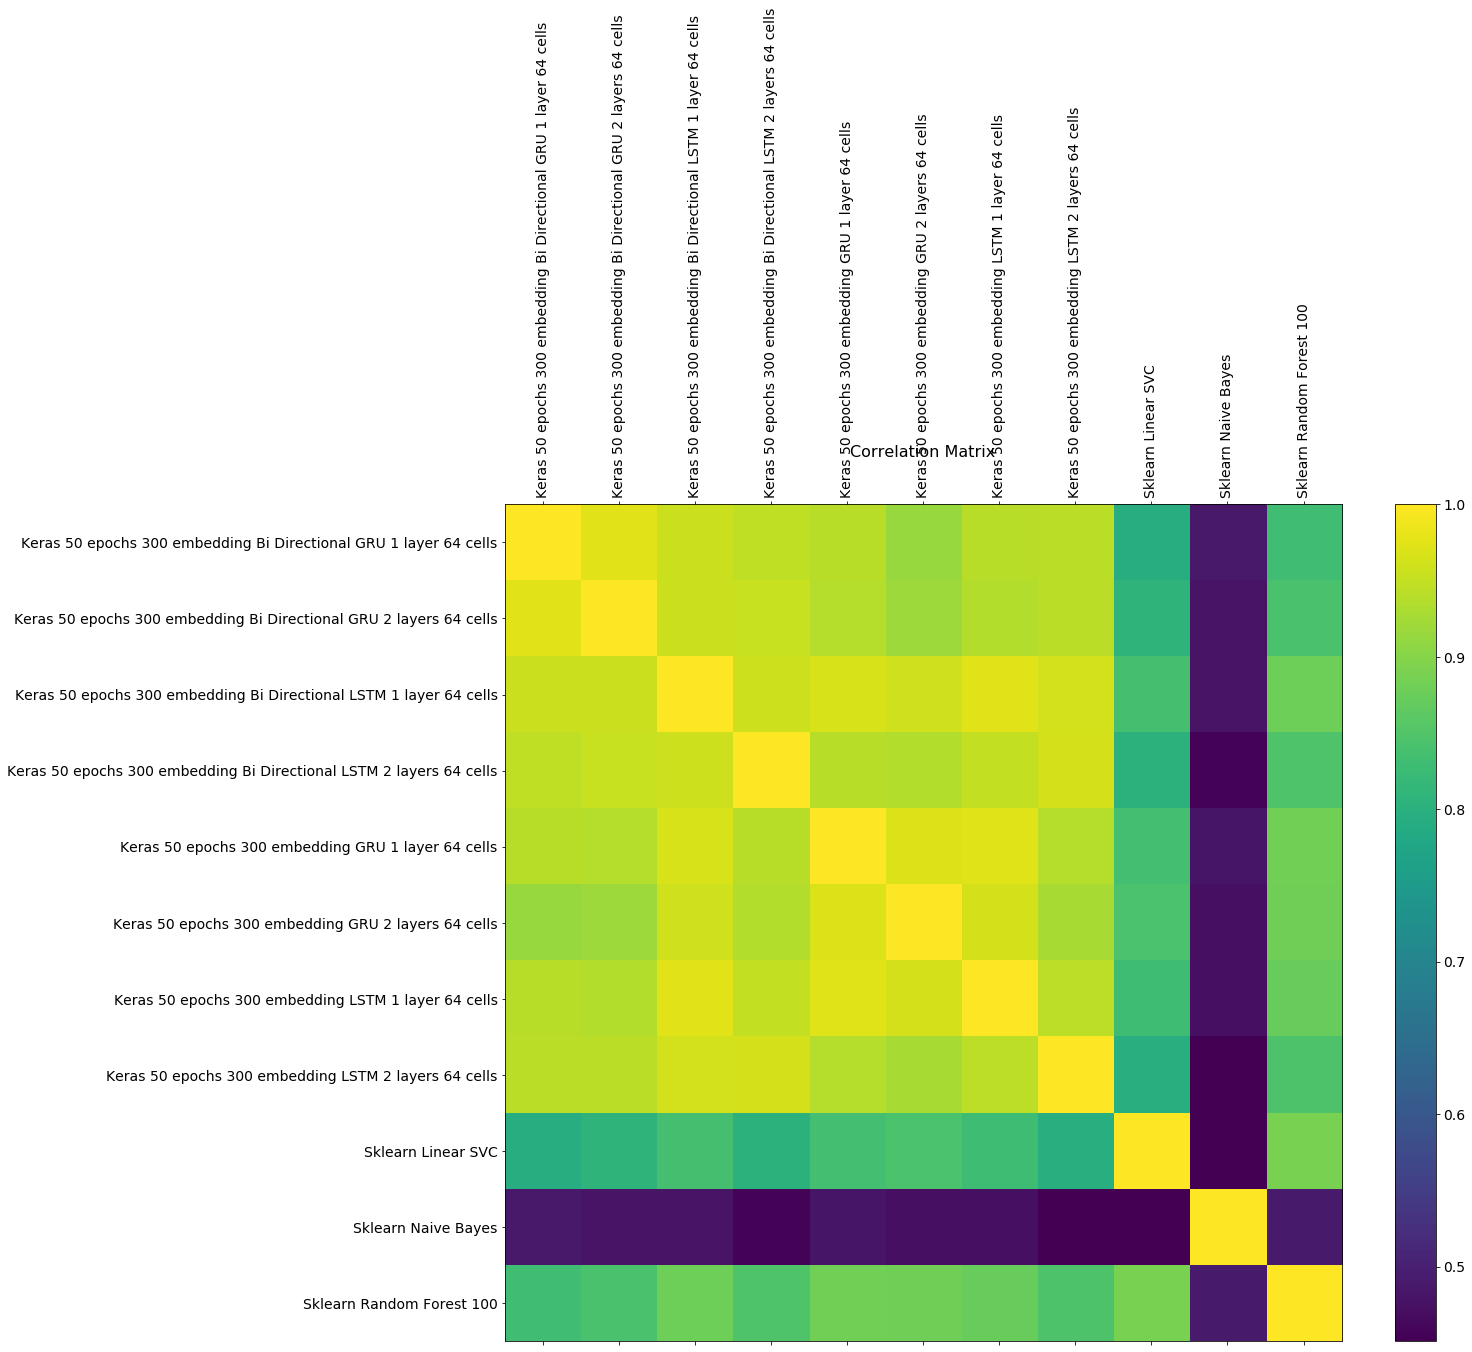

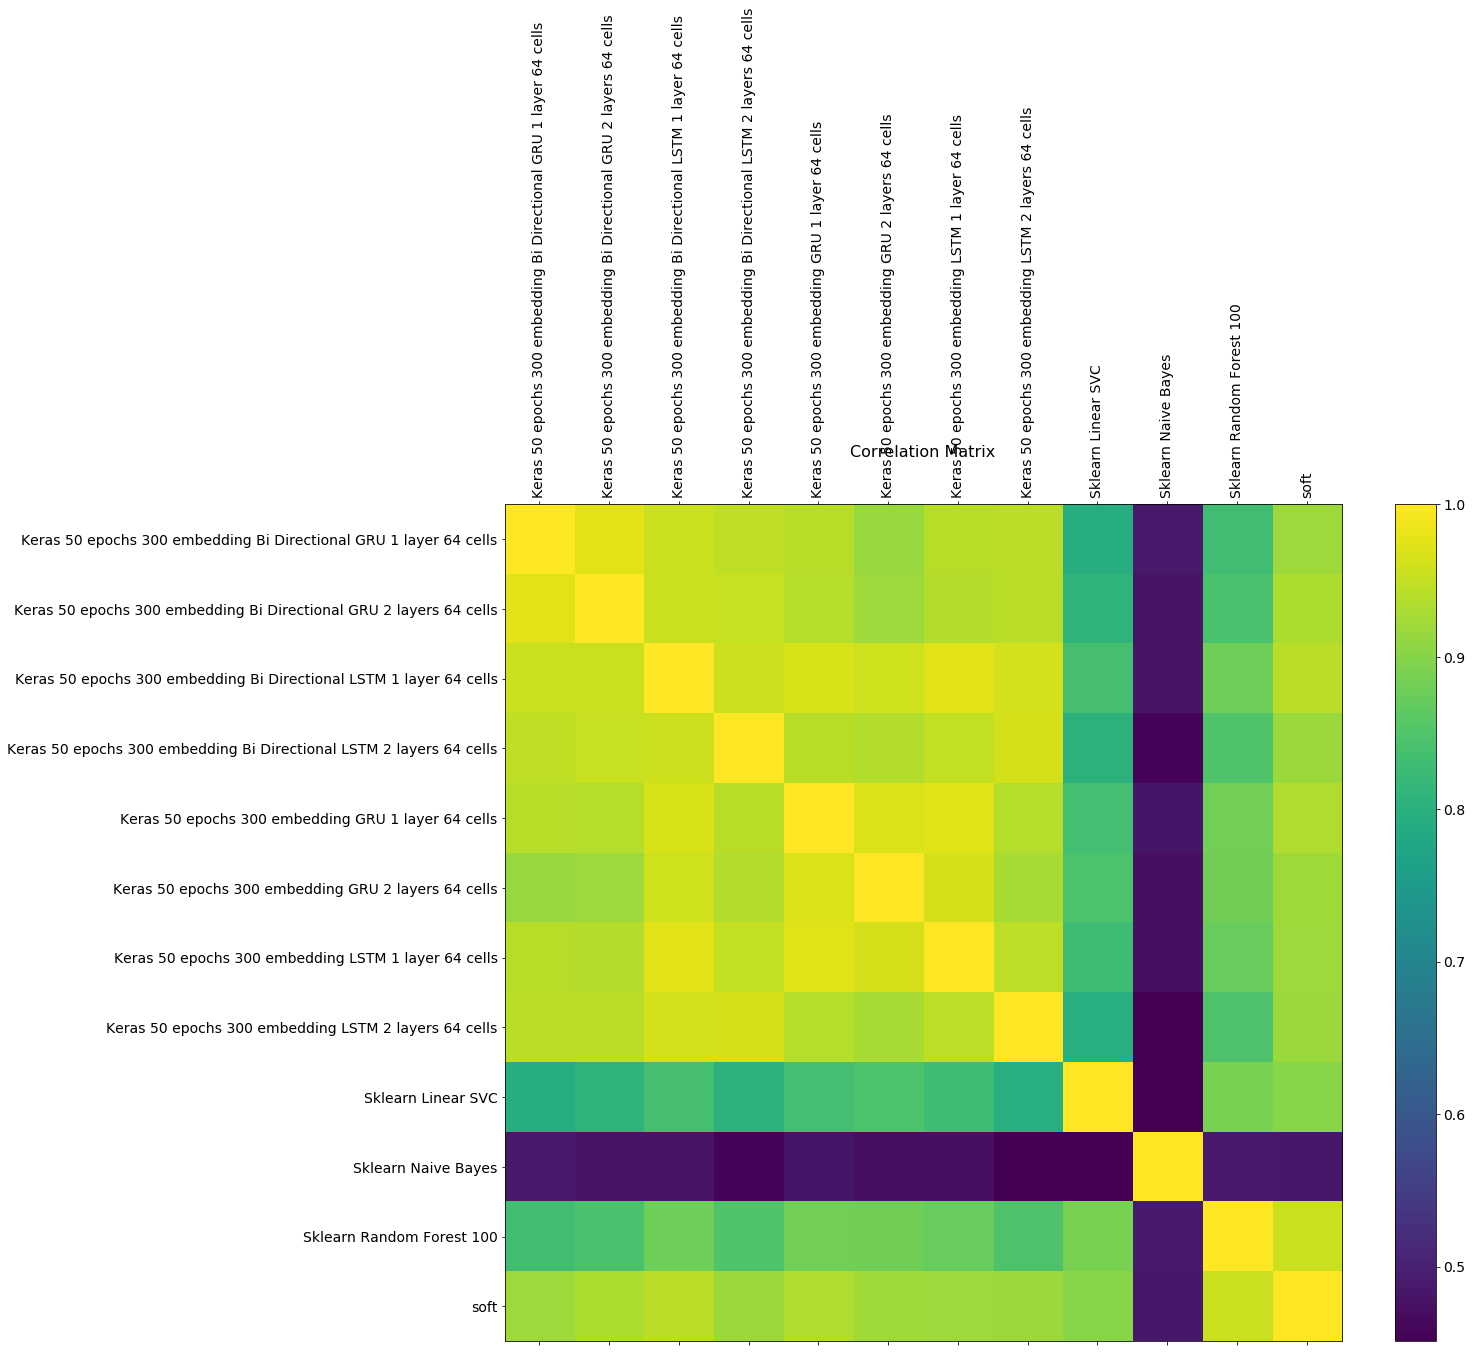

1 Sklearn Random Forest 100
2 Keras 50 epochs 300 embedding LSTM 2 layers 64 cells
Sklearn Random Forest 100 was right and Keras 50 epochs 300 embedding LSTM 2 layers 64 cells was wrong on these
class 1
i'm so tempted to eat  mcdonald 's my parents brought & ready to give up on this healthy diet lmao
 McDonald 's is trash!!!   
 McDonald 's is so trash to me & that's all these hoes wanna eat so ima starve til we get back to Atlanta
I don't like  McDonald 's
I have health class in the morning  I tell myself " okay no more junk food " class ends  Guess what's in front of me and around the school       * food truck      * Jack in the box       *  McDonald 's       * little Ceasers  Me " My diet starts tomorrow "
When people are shocked that I've never ate at  McDonald 's, KFC, Burger King etc. doesn't make me sad I 100% feel like I'm not missing out on anything tbh. It's all artificial  
Negative. Pancakes are more time consuming than eggs. I don't like  McDonald 's but I tried to at leas

In [13]:
#% use 10 folds cv
folds = 10

#% Blending_ratio
#% We train on 1-blend_rate, blend on blend_rate
blend_rate = 0.2

blending_path = './blending' + str(int(blend_rate*100))

#% Use only 1 dataset
dataset = datasets[0]

kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
current_fold = 1

dataset_path = os.path.join(blending_path, dataset.name)

#% First cv fold as example
#print(kfold.split(dataset.X, dataset.y))
train_idx, test_idx = next(kfold.split(dataset.X, dataset.y))
print('-----')
print('Fold', current_fold)
train, test = dataset.split_index(train_idx, test_idx)

#% Blend on 20% of the train set
train, blend = dataset.split(blend_rate)

fold_path = os.path.join(dataset_path, str(current_fold) + '_' + str(folds))

Zblend = None
Ztest = None

name1 = ''
name2 = ''

#% Build the prediction matrices
#% It is a concatenation of the predictions of all models
for d in next(os.walk(fold_path))[1]:
    #% RF
    if 'Random' in d:
        name1 = d
    #% Deep rnn
    if 'LSTM' in d:
        name2 = d

    model_dir = os.path.join(fold_path, d)
    preds_test_file = os.path.join(model_dir, 'preds_test.csv')
    preds_blend_file = os.path.join(model_dir, 'preds_blend.csv')

    if Zblend is None:
        Zblend = pd.read_csv(preds_blend_file, names=[d], header=None)
        Ztest = pd.read_csv(preds_test_file, names=[d], header=None)
    else:
        df = pd.read_csv(preds_blend_file, names=[d], header=None)
        Zblend = pd.concat([Zblend, df], axis=1)
        df = pd.read_csv(preds_test_file, names=[d], header=None)
        Ztest = pd.concat([Ztest, df], axis=1)
df_corr(Ztest, "correlation_1.png")

#% Train a logReg on the predictions
lr = LogisticRegression(solver="lbfgs", max_iter=2000, n_jobs = -1)
lr.fit(Zblend, blend.y)

#% Test the blending
soft = lr.predict_proba(Ztest)[:,1]
df = pd.DataFrame(soft, columns=['soft'])
Ztest = pd.concat([Ztest, df], axis=1)
df_corr(Ztest, "correlation_2.png")

df = pd.DataFrame(test.y, columns=['true'])
Ztest = pd.concat([Ztest, df], axis=1)
df = pd.DataFrame(test.texts, columns=['text'])
Ztest = pd.concat([Ztest, df], axis=1)
save_diffs(Ztest, name1, name2, 'true')

print('=============================================')
print(name1, 'was right and', name2, 'was wrong on these')
print('class 1')
Ztest['text'][Ztest['res'] == 1][Ztest['true'] == 1].apply(print)
print('=============================================')
print('class 0')
Ztest['text'][Ztest['res'] == 1][Ztest['true'] == 0].apply(print)

print('=============================================')
print(name2, 'was right and', name1, 'was wrong on these')
print('class 1')
Ztest['text'][Ztest['res'] == -1][Ztest['true'] == 1].apply(print)
print('=============================================')
print('class 0')
Ztest['text'][Ztest['res'] == -1][Ztest['true'] == 0].apply(print)
print()

-----
Fold 1


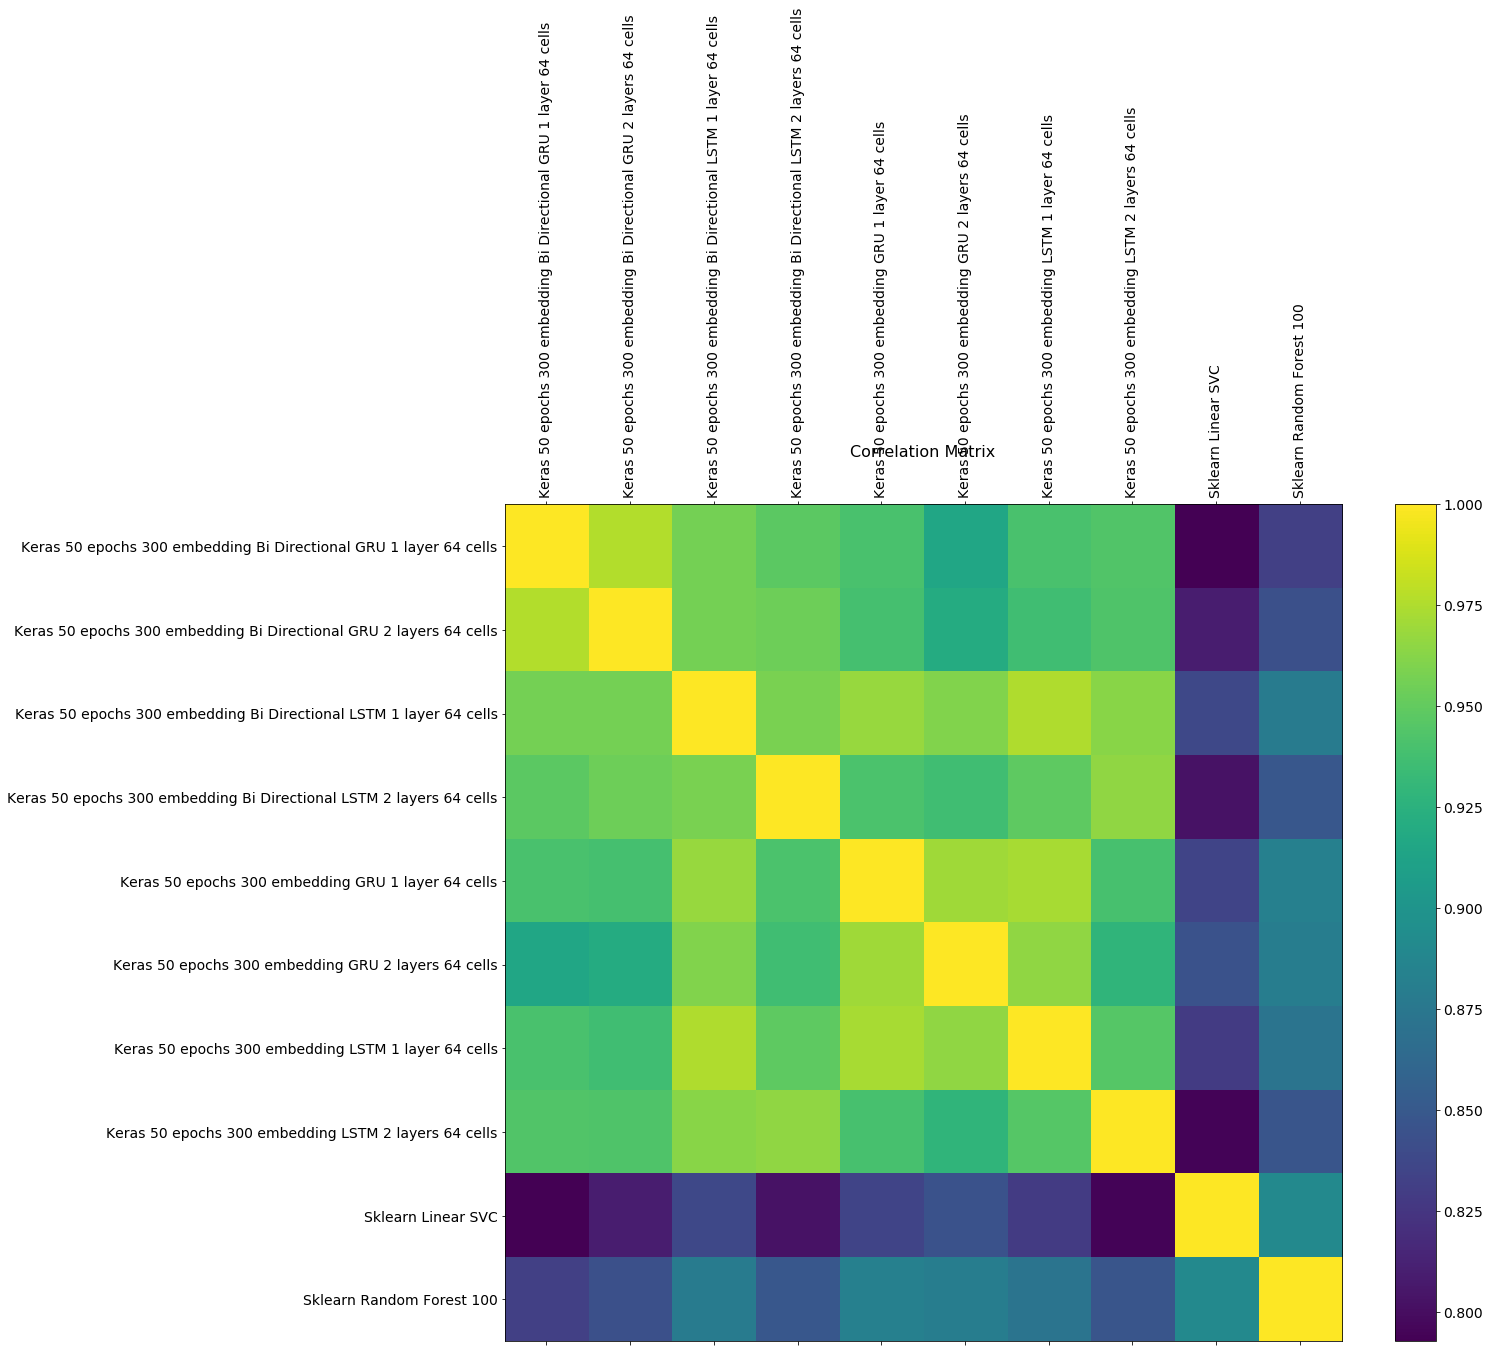

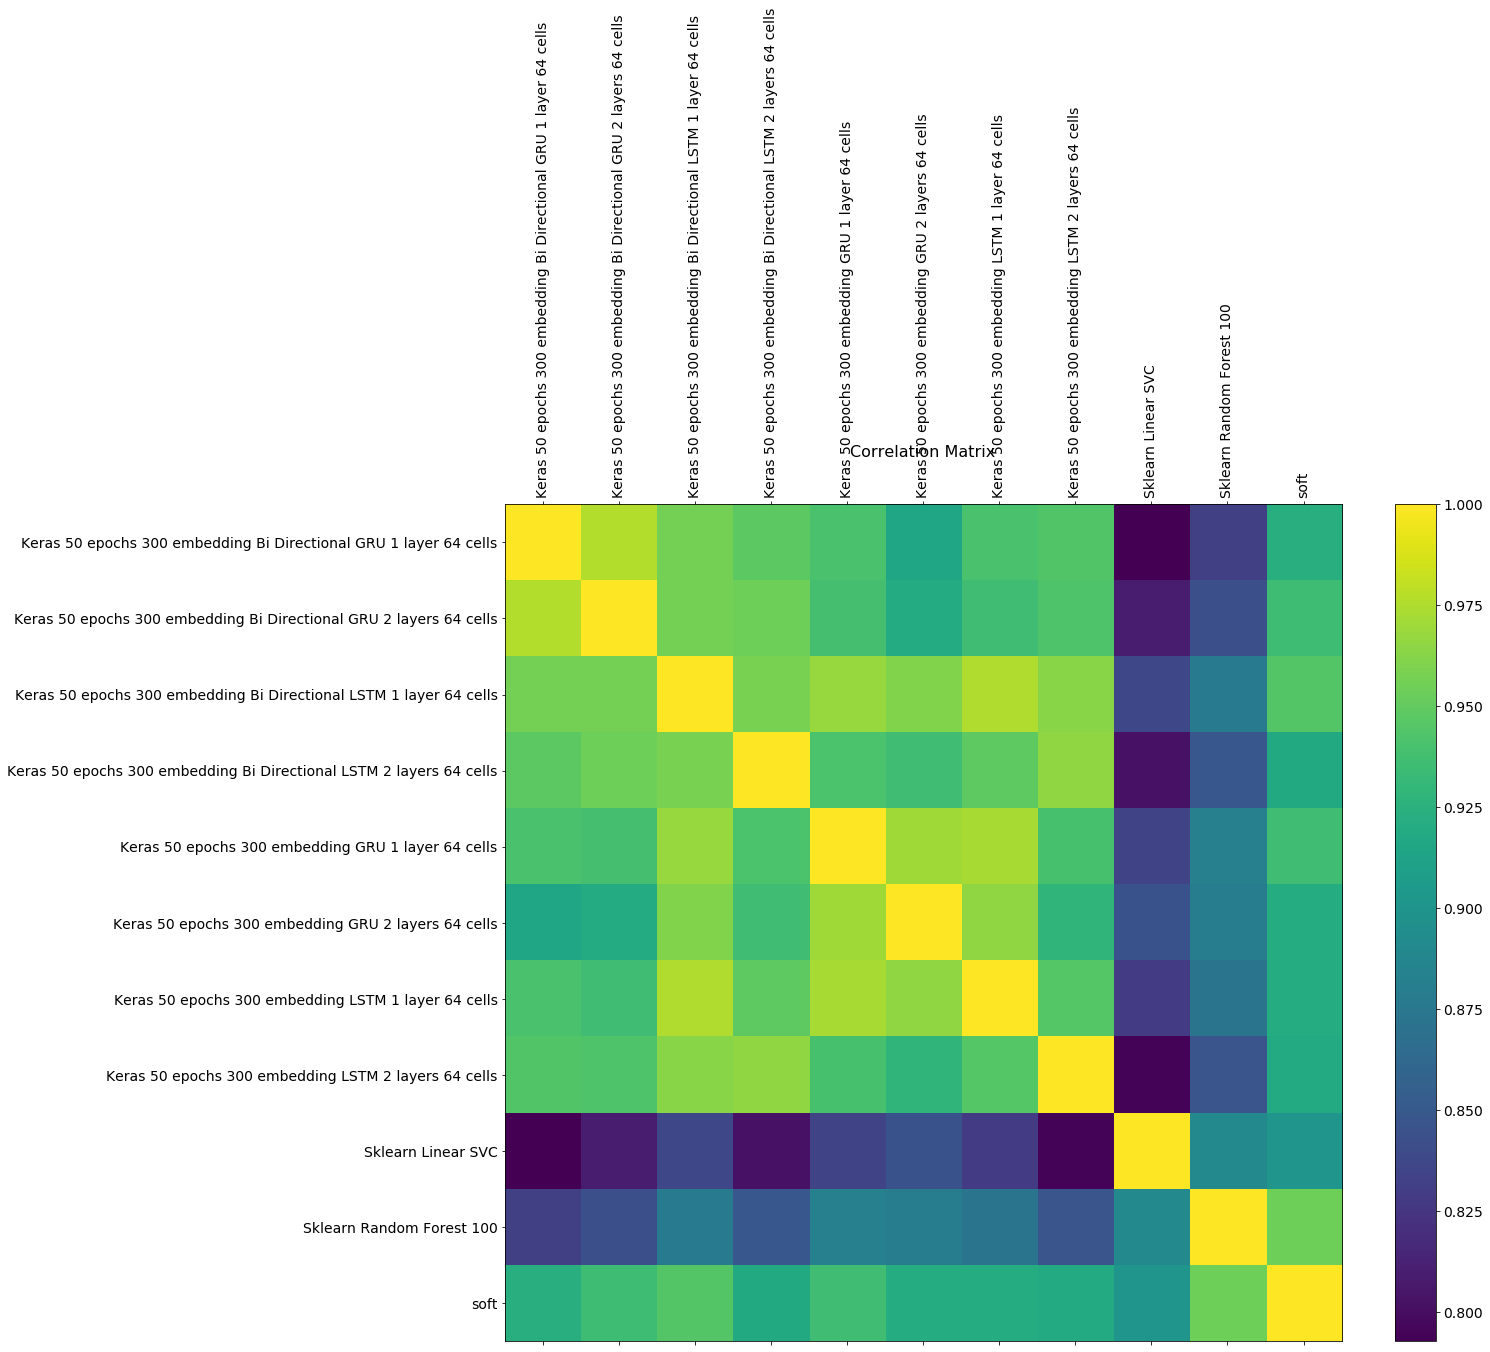

1 Sklearn Random Forest 100
2 Keras 50 epochs 300 embedding LSTM 2 layers 64 cells
Sklearn Random Forest 100 was right and Keras 50 epochs 300 embedding LSTM 2 layers 64 cells was wrong on these
class 1
i'm so tempted to eat  mcdonald 's my parents brought & ready to give up on this healthy diet lmao
 McDonald 's is trash!!!   
 McDonald 's is so trash to me & that's all these hoes wanna eat so ima starve til we get back to Atlanta
I don't like  McDonald 's
I have health class in the morning  I tell myself " okay no more junk food " class ends  Guess what's in front of me and around the school       * food truck      * Jack in the box       *  McDonald 's       * little Ceasers  Me " My diet starts tomorrow "
When people are shocked that I've never ate at  McDonald 's, KFC, Burger King etc. doesn't make me sad I 100% feel like I'm not missing out on anything tbh. It's all artificial  
Negative. Pancakes are more time consuming than eggs. I don't like  McDonald 's but I tried to at leas

In [14]:
#% use 10 folds cv
folds = 10

#% Blending_ratio
#% We train on 1-blend_rate, blend on blend_rate
blend_rate = 0.2

blending_path = './blending' + str(int(blend_rate*100))

#% Use only 1 dataset
dataset = datasets[0]

kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
current_fold = 1

dataset_path = os.path.join(blending_path, dataset.name)

#% First cv fold as example
#print(kfold.split(dataset.X, dataset.y))
train_idx, test_idx = next(kfold.split(dataset.X, dataset.y))
print('-----')
print('Fold', current_fold)
train, test = dataset.split_index(train_idx, test_idx)

#% Blend on 20% of the train set
train, blend = dataset.split(blend_rate)

fold_path = os.path.join(dataset_path, str(current_fold) + '_' + str(folds))

Zblend = None
Ztest = None

name1 = ''
name2 = ''

#% Build the prediction matrices
#% It is a concatenation of the predictions of all models
for d in next(os.walk(fold_path))[1]:
    if 'Naive' in d:
        continue
    #% RF
    if 'Random' in d:
        name1 = d
    #% Deep rnn
    if 'LSTM' in d:
        name2 = d

    model_dir = os.path.join(fold_path, d)
    preds_test_file = os.path.join(model_dir, 'preds_test.csv')
    preds_blend_file = os.path.join(model_dir, 'preds_blend.csv')

    if Zblend is None:
        Zblend = pd.read_csv(preds_blend_file, names=[d], header=None)
        Ztest = pd.read_csv(preds_test_file, names=[d], header=None)
    else:
        df = pd.read_csv(preds_blend_file, names=[d], header=None)
        Zblend = pd.concat([Zblend, df], axis=1)
        df = pd.read_csv(preds_test_file, names=[d], header=None)
        Ztest = pd.concat([Ztest, df], axis=1)
df_corr(Ztest, "correlation_3.png")

#% Train a logReg on the predictions
lr = LogisticRegression(solver="lbfgs", max_iter=2000, n_jobs = -1)
lr.fit(Zblend, blend.y)

#% Test the blending
soft = lr.predict_proba(Ztest)[:,1]
df = pd.DataFrame(soft, columns=['soft'])
Ztest = pd.concat([Ztest, df], axis=1)
df_corr(Ztest, "correlation_4.png")

df = pd.DataFrame(test.y, columns=['true'])
Ztest = pd.concat([Ztest, df], axis=1)
df = pd.DataFrame(test.texts, columns=['text'])
Ztest = pd.concat([Ztest, df], axis=1)
save_diffs(Ztest, name1, name2, 'true')

print('=============================================')
print(name1, 'was right and', name2, 'was wrong on these')
print('class 1')
Ztest['text'][Ztest['res'] == 1][Ztest['true'] == 1].apply(print)
print('=============================================')
print('class 0')
Ztest['text'][Ztest['res'] == 1][Ztest['true'] == 0].apply(print)

print('=============================================')
print(name2, 'was right and', name1, 'was wrong on these')
print('class 1')
Ztest['text'][Ztest['res'] == -1][Ztest['true'] == 1].apply(print)
print('=============================================')
print('class 0')
Ztest['text'][Ztest['res'] == -1][Ztest['true'] == 0].apply(print)
print()

Looks like random forest has right on 0 class 0 over deep learning algo.  
=> RF is bad at identifying class 0.  
=> RF has some key-words (probably regexp ones (trash)  
=> LSTM finds complex dependencies

However it has right on a lot of class 1.

Deep is more balanced

Some of the bad tags of RF are actually edgy cases, badly tagged :  
class 1 : I don't trust people who don't eat  McDonald 's
class 0 : I Don't eat trash so yeah, I def hate  Mc Donald 's

Naive bayes is uncorrelated to output AND other estimators => bad

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(input='content', analyzer='word')

cv.fit(train.texts)
encoded_test = cv.transform(test.texts)

In [16]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=1, init='pca')
tsne = tsne_model.fit_transform(encoded_test.toarray())

In [17]:
def get_class(row):
    return row['res']

Ztest['class'] = Ztest.apply(get_class, axis=1)
labels = Ztest['class'].values
labels[np.abs(labels) != 1] = 0

texts_ = test.texts.copy()

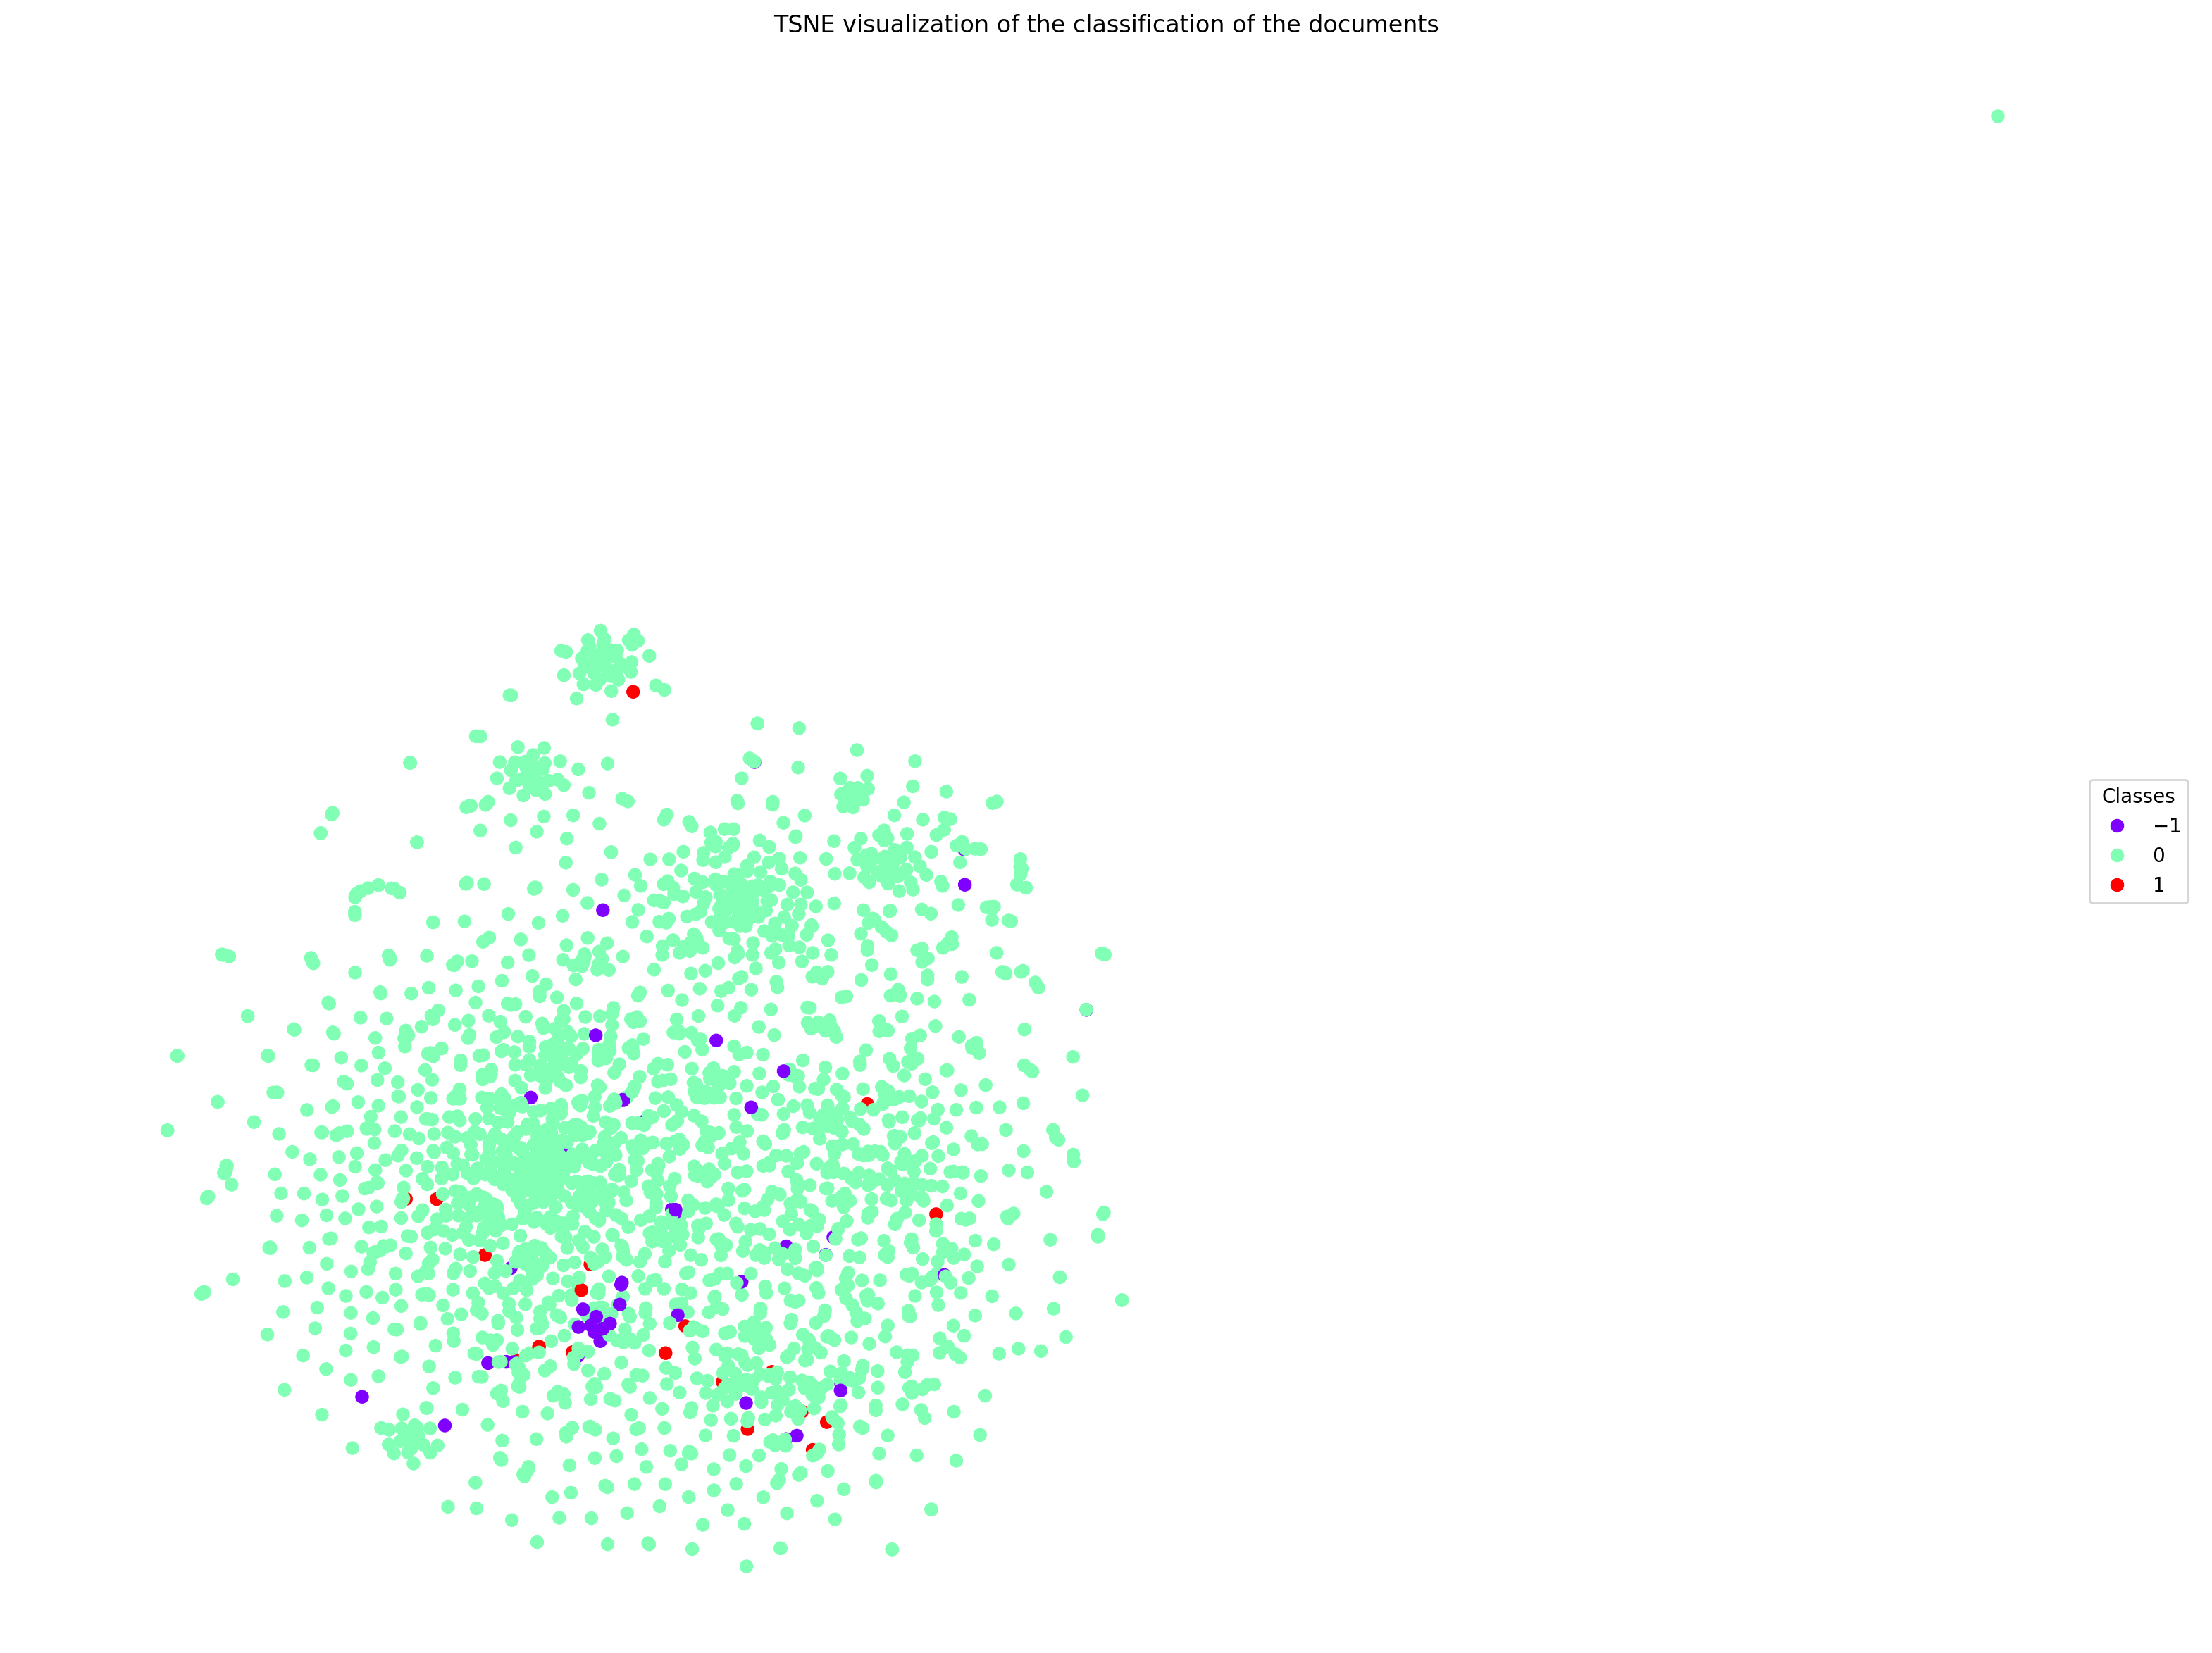

In [18]:
import matplotlib.pyplot as plt
#% Plot, leave axis for legend
fig, ax = plt.subplots(figsize=(20, 15), dpi=200)
scatter = plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap='rainbow')

ax.set_xlim((min(tsne[:,0])*1.3, max(tsne[:,0])*1.1+3))
legend1 = ax.legend(*scatter.legend_elements(), loc="right", title="Classes")
plt.axis('off')
plt.title('TSNE visualization of the classification of the documents')
plt.savefig('tsne_1.png')

plt.show()

In [19]:
# 1 is an outsider, let's remove it
mean_norm = np.array([np.linalg.norm(tsne - tsne[i], axis=1).mean() for i in range(tsne.shape[0])])
imax = np.argmax(mean_norm)

In [20]:
labels = np.array([labels[i] for i in range(len(labels)) if i != imax])
tsne = np.array([tsne[i] for i in range(tsne.shape[0]) if i != imax])
texts_ = np.array([texts_[i] for i in range(texts_.shape[0]) if i != imax])

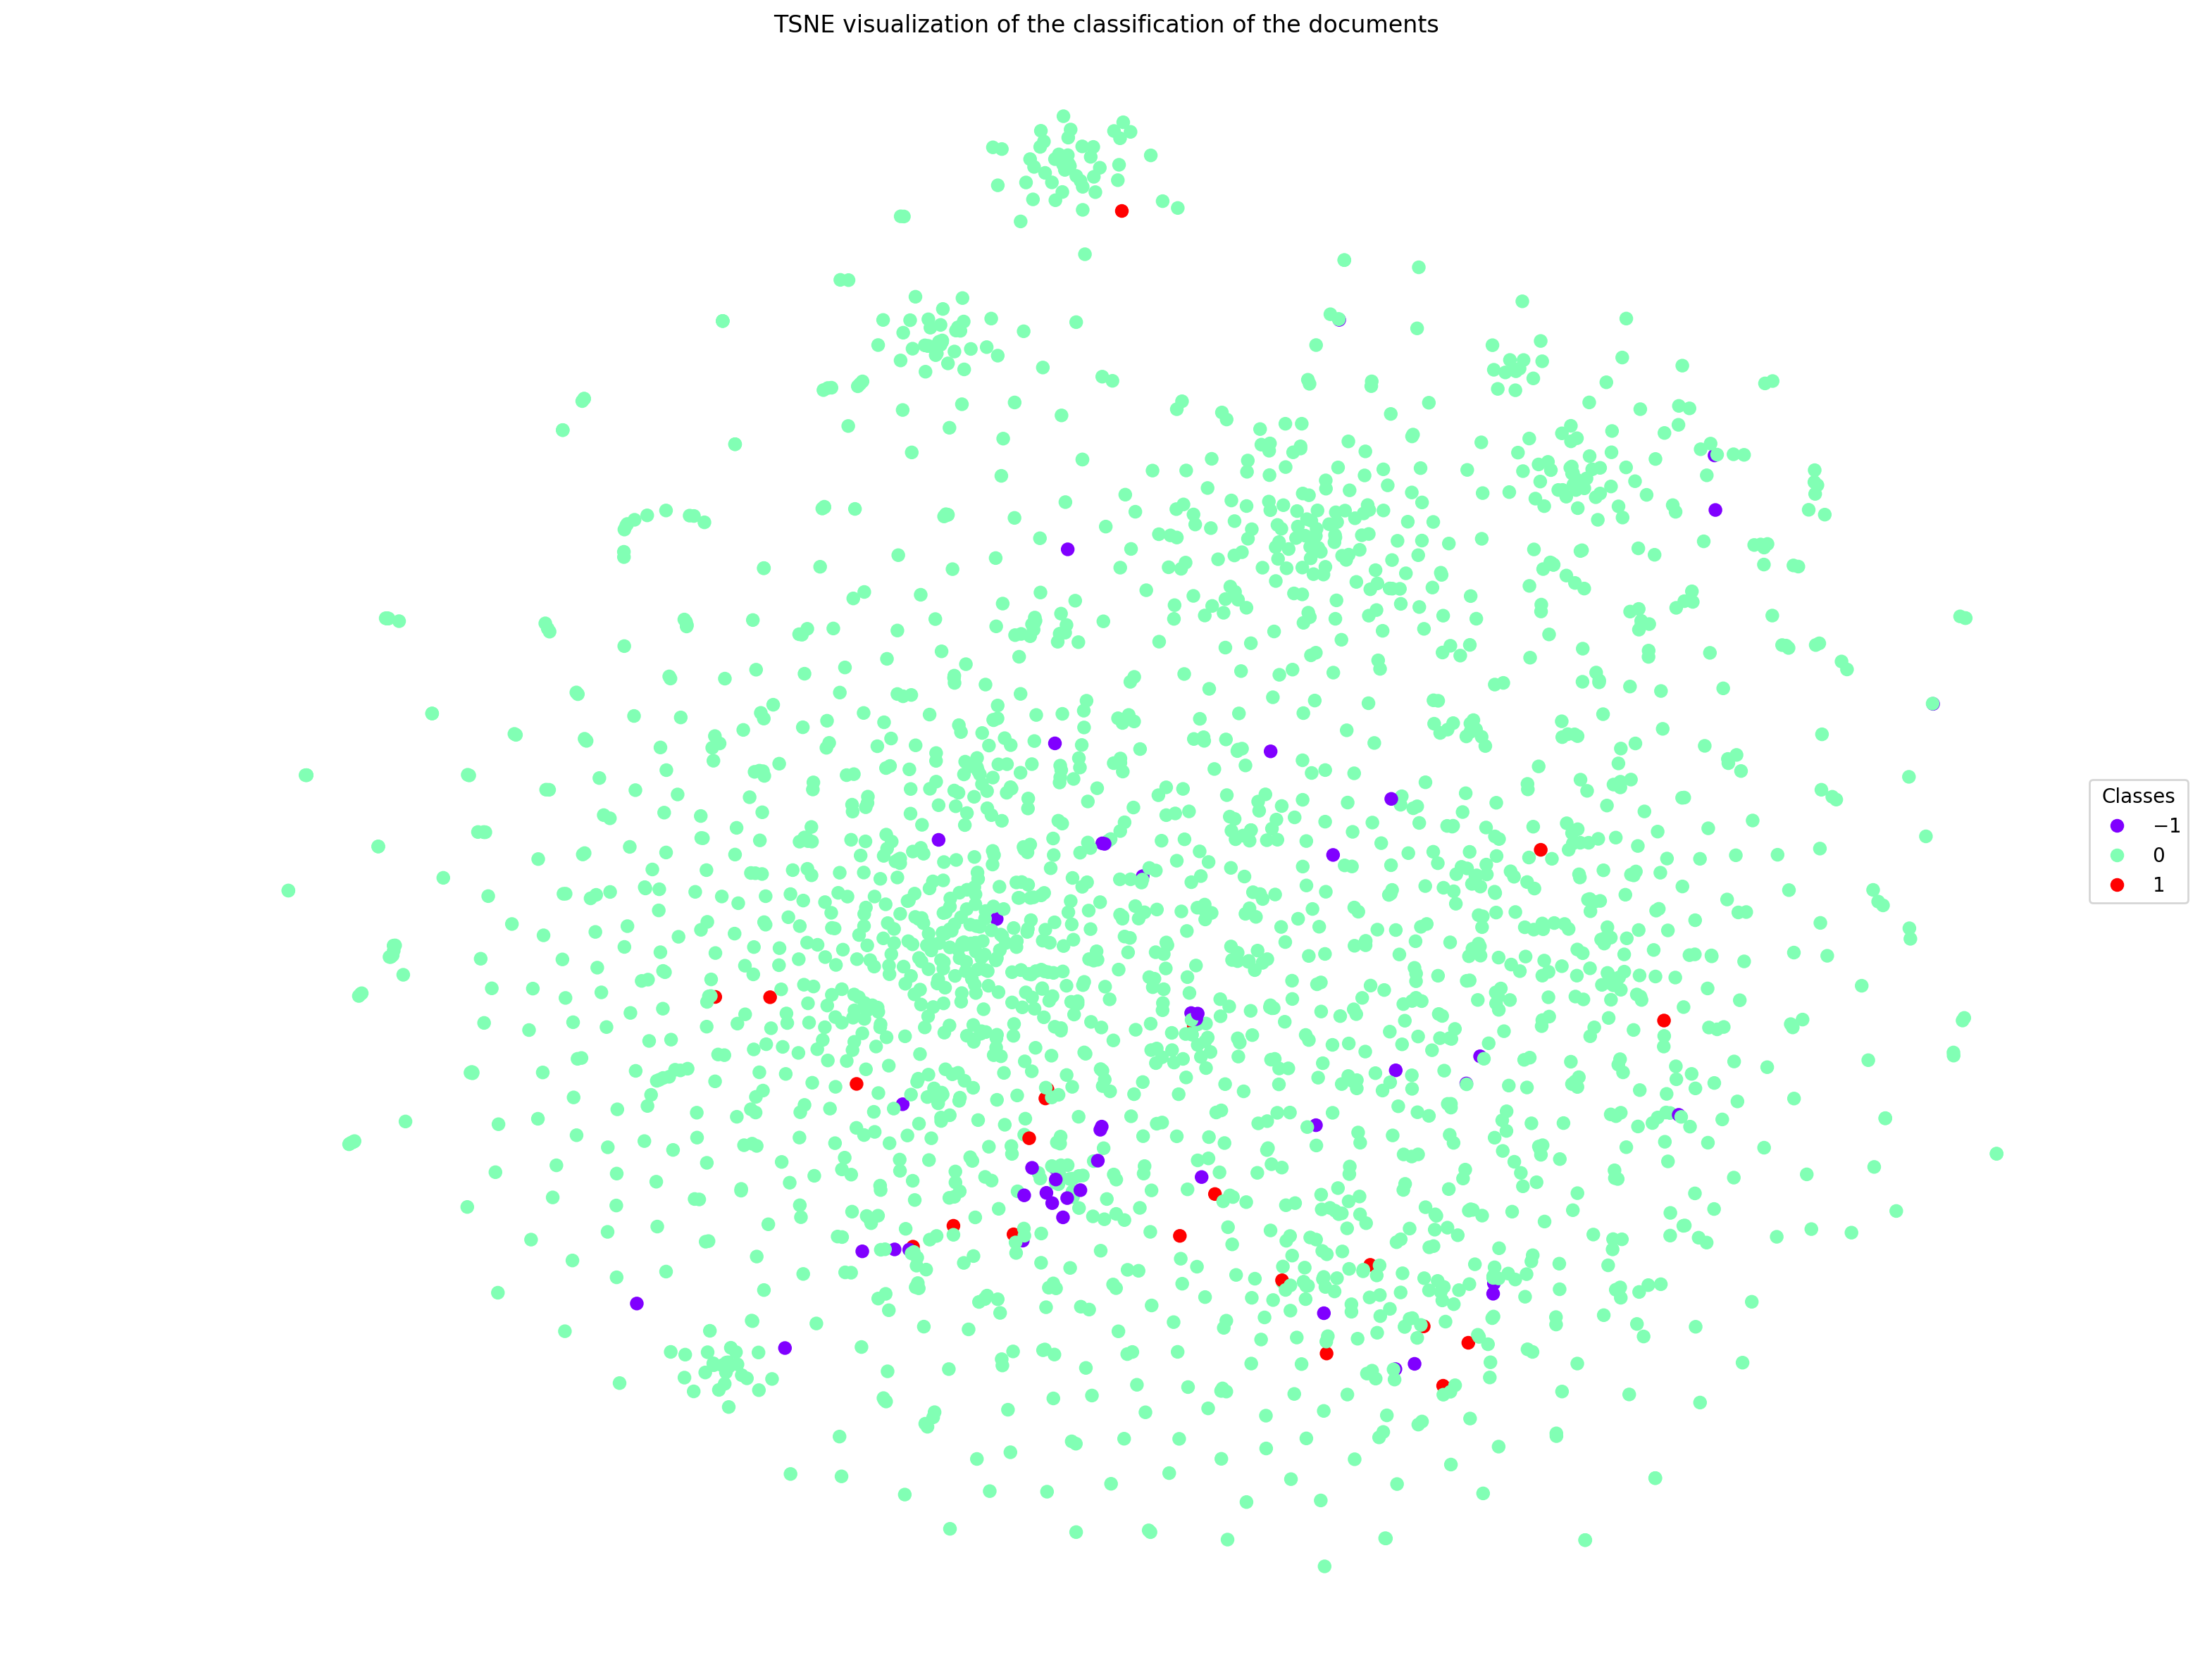

In [21]:
import matplotlib.pyplot as plt
#% Plot, leave axis for legend
fig, ax = plt.subplots(figsize=(20, 15), dpi=200)
scatter = plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap='rainbow')

ax.set_xlim((min(tsne[:,0])*1.3, max(tsne[:,0])*1.1+3))
legend1 = ax.legend(*scatter.legend_elements(), loc="right", title="Classes")
plt.axis('off')
plt.title('TSNE visualization of the classification of the documents')
plt.savefig('tsne_2.png')

plt.show()

In [22]:
tsne_backup = tsne.copy()
labels_backup = labels.copy()
texts_backup = texts_.copy()

In [23]:
tsne = tsne_backup.copy()
labels = labels_backup.copy()
texts_ = texts_backup.copy()
# get cluster of class -1
while len(labels[labels == -1]) != 15:
    mean_norm = np.array([(np.linalg.norm(tsne[labels==-1] - tsne[i], axis=1).mean(), i) for i in range(tsne.shape[0]) if labels[i] == -1])
    mean_norm = sorted(mean_norm, key=lambda x:x[0], reverse=True)
    imax = int(mean_norm[0][1])
    labels = np.array([labels[i] for i in range(len(labels)) if i != imax])
    tsne = np.array([tsne[i] for i in range(tsne.shape[0]) if i != imax])
    texts_ = np.array([texts_[i] for i in range(texts_.shape[0]) if i != imax])

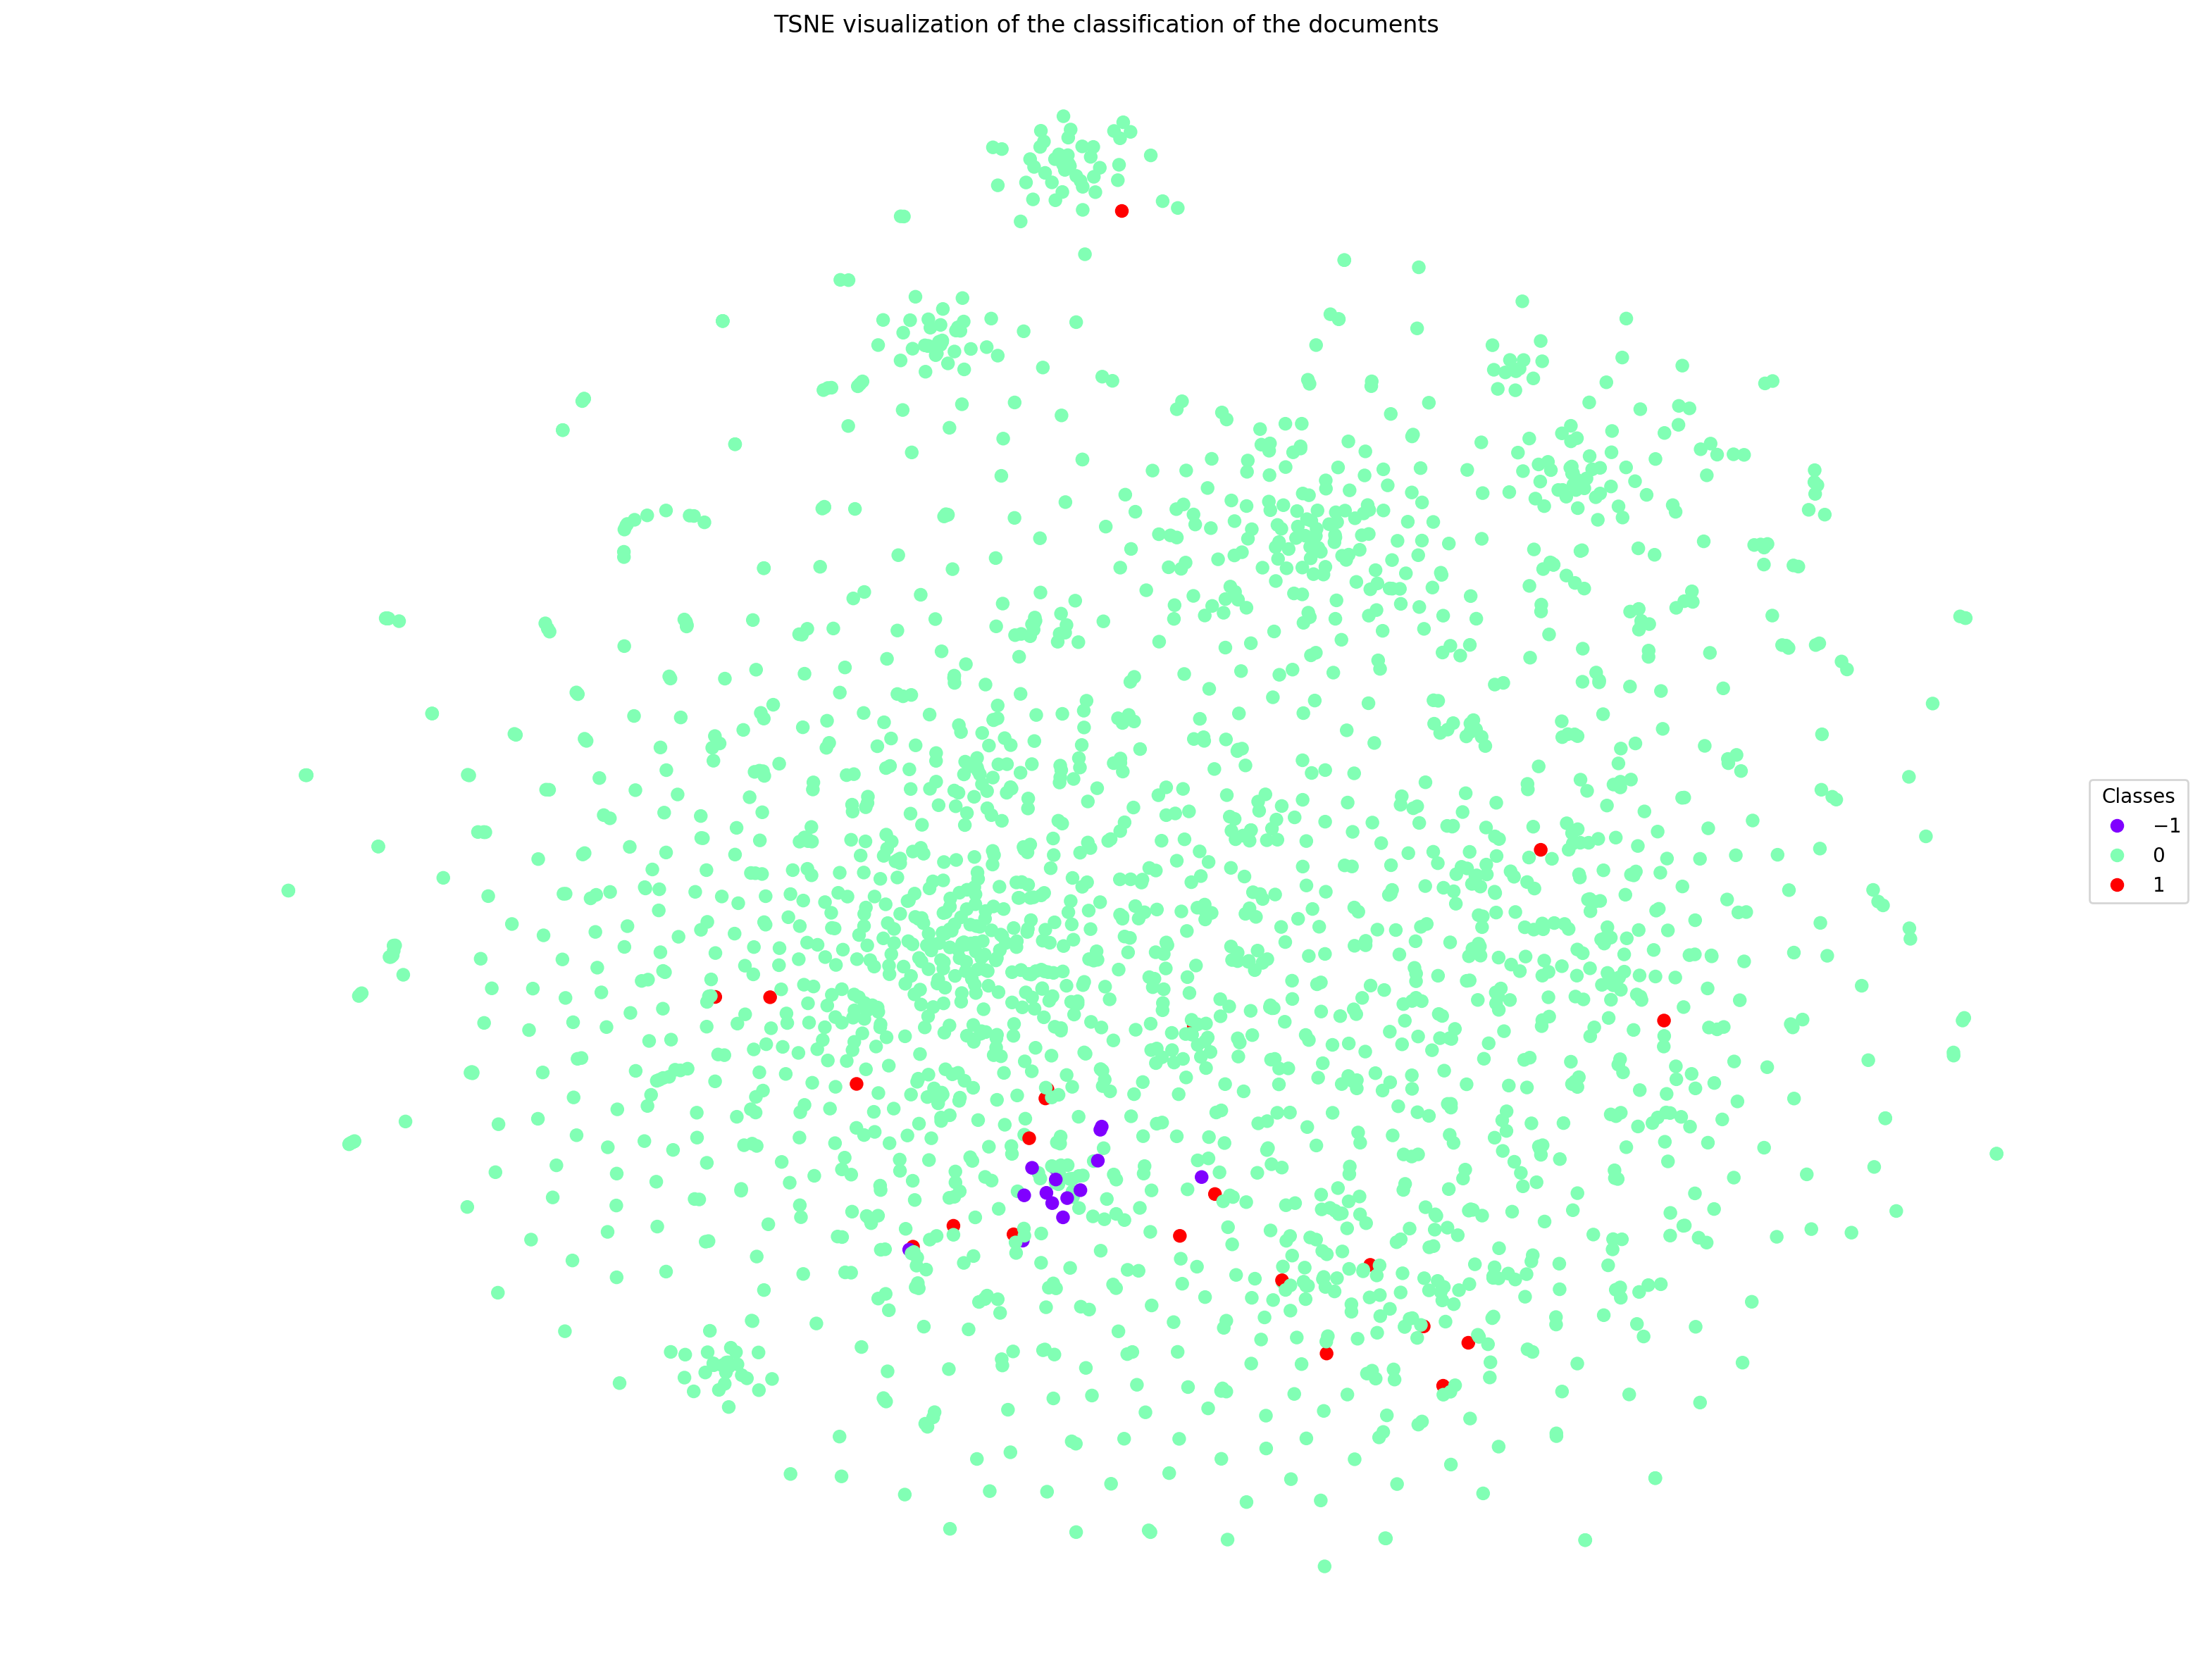

In [24]:
import matplotlib.pyplot as plt
#% Plot, leave axis for legend
fig, ax = plt.subplots(figsize=(20, 15), dpi=200)
scatter = plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap='rainbow')

ax.set_xlim((min(tsne[:,0])*1.3, max(tsne[:,0])*1.1+3))
legend1 = ax.legend(*scatter.legend_elements(), loc="right", title="Classes")
plt.axis('off')
plt.title('TSNE visualization of the classification of the documents')
plt.savefig('tsne_3.png')

plt.show()

In [25]:
texts_[labels==-1]

array(["Now I remember why I don't eat  McDonald 's... got serious ring of fire going on  ",
       "I don't eat  McDonald 's everyday, but every time I go I get nuggets.",
       "I'm so hungry bad as I hate  McDonald 's I'll eat some",
       "This boy doesn't listen for shit I done told him over a million times I don't eat fat food period ! Only chick fli a here & there but Burger King  McDonald  etc is over rated I don't eat that shit !",
       "I'm so hungry I could eat a  McDonald 's salad  ",
       'I see so many "health-conscious" fat people that say that they don\'t eat  McDonald \'s. Just shut up bruh I don\'t believe you. You can say it\'s unhealthy and I have no rebuttal. But saying that it\'s "nasty" is a blasphemous statement lol. Just drink your water and go    ',
       "something made me crave chicken nuggets from  McDonald 's and i don't even eat  McDonald 's ??????",
       "You're trash if you still eat  McDonald 's.",
       "She fuckin', she an eater, she gon' s

Class 1 is :

I don't know y I really need to start my diet but I'm over here saying I want some  McDonald 's   @ McDonalds   should I start my diet instead of going to  McDonald 's  
Now I remember why I don't eat  McDonald 's... got serious ring of fire going on    
This boy doesn't listen for shit I done told him over a million times I don't eat fat food period ! Only chick fli a here & there but Burger King  McDonald  etc is over rated I don't eat that shit !  
Kids that work there spit and lick   the cheese before it goes on your burger. I sent my order back when I saw them doing it and laughing until I called the manager. I don't ever eat at  McDonald 's and I tell my friends. By by  
I've gotta stop eating  McDonald 's before I get really fucking fat   
You're trash if you still eat  McDonald 's.  
I don't eat  McDonald 's but I'll go with chic fil a or whataburger     https://  twitter.com/13swiftpuffs/s  tatus/1025782224304660480     ...    
She fuckin', she an eater, she gon' swallow A double cheese but I don't eat  McDonald 's  
 McDonald 's is trash in every other city I've had it    
Why you eating salad at  McDonald 's?..     https://  twitter.com/WSBT/status/10  29468395987771392     ...    
I don't trust people who don't eat  McDonald 's   